# Snapchat Political Ads
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
TODO

### Baseline Model
For our baseline model, we used SimpleImputer and OneHotEncoder for the categorical columns. For the numerical columns, we just used SimpleImputer. Because all our our qualitative columns were of nominal types, so that enabled us to just group all the qualitiative columns together through our pipeline. It is important to note that the accuracy of this baseline pipeline is: 

r-squared: 0.4727801201580596

rmse: 23575.742207957916
### Final Model
TODO

### Fairness Evaluation
TODO

# Code

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import re
from sklearn import metrics
import datetime as dt 

In [263]:
eighteen = pd.read_csv("2018.csv")
nineteen = pd.read_csv("2019.csv")
result = pd.concat([eighteen, nineteen])
result = result.reset_index(drop=True)
dates = result[['StartDate', 'EndDate', 'CreativeUrl']]
result.columns

Index(['ADID', 'CreativeUrl', 'Spend', 'Impressions', 'StartDate', 'EndDate',
       'OrganizationName', 'BillingAddress', 'CandidateBallotInformation',
       'PayingAdvertiserName', 'Gender', 'AgeBracket', 'CountryCode',
       'RegionID', 'ElectoralDistrictID', 'LatLongRad', 'MetroID', 'Interests',
       'OsType', 'Segments', 'LocationType', 'Language',
       'AdvancedDemographics', 'Targeting Connection Type',
       'Targeting Carrier (ISP)', 'Targeting Geo - Postal Code',
       'CreativeProperties'],
      dtype='object')

Prediction: We will try to predict the reach, or the number of views, of an ad. This is a regression problem. 

### Baseline Model

In [264]:
# changing all dates to datetime objects
result['StartDate'] = result['StartDate'].str[:-1]
result['EndDate'] = result['EndDate'].str[:-1]

# StartDate = pd.to_datetime(result['StartDate'])
# result['EndDate'] = pd.to_datetime(result['EndDate'], errors='coerce')

# Segments
result['Segments'] = result['Segments'].fillna("Not Provided by Advertiser")

# these cols need to all be filled nans with the respective country
country_cols = ["RegionID", "ElectoralDistrictID","LatLongRad","MetroID","Targeting Geo - Postal Code"]

for i in range(len(country_cols)):
    result[country_cols[i]] = result[country_cols[i]].fillna(result["CountryCode"])

# these cols need to all be filled nans with just string "all"
all_cols = ["Interests","Language","AdvancedDemographics","Gender","AgeBracket","OsType"]
    
for i in range(len(all_cols)):
    result[all_cols[i]] = result[all_cols[i]].fillna("All")
    
nan_cols = ['CandidateBallotInformation', 'LocationType', 'CreativeProperties']
for i in range(len(nan_cols)): 
    result[nan_cols[i]] = result[nan_cols[i]].fillna("Not provided")
    
# EndDate                         fill with "Present" or current time
result['EndDate'] = str(result['EndDate'].fillna(datetime.utcnow()))
# Gender                          fill with "All"
result['Gender'] = result['Gender'].fillna("All")
result = result.drop(columns=['Targeting Connection Type', "Targeting Carrier (ISP)"])
#CandidateBallotInformation; LocationType; Creative Properties 

In [265]:
X = result.drop(['Impressions'], axis=1)
y = result.Impressions

In [ ]:
# TODO
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

cats = Pipeline([
    
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl = Pipeline([('feats', ct), ('reg', LinearRegression())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl.fit(X_tr, y_tr)
rsquared = pl.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))


### Final Model

In [269]:
dates['StartDate'] = pd.to_datetime(dates['StartDate'])
dates['EndDate'] = pd.to_datetime(dates['EndDate'], errors='coerce')
# EndDate                         fill with "Present" or current time
dates['EndDate'] = dates['EndDate'].fillna(datetime.utcnow())
# Quantitative: Impressions, Spend, Duration
# Nominal: CountryCode, Gender, MediaType

In [270]:
result = result[['Impressions', 'StartDate', 'EndDate', 'Spend','Gender', 'CountryCode']]
X = result.drop(['Impressions'], axis=1)
y = result.Impressions

In [271]:
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.6620161651937161
rmse: 100627.87472035264


In [272]:
#New feature: Duration 
result['Duration'] = abs(dates['EndDate'] - dates['StartDate'])
result["Duration"] = round(result['Duration'].apply(lambda x: x.days * 24 + x.seconds // 3600))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [273]:
result = result[['Impressions', 'StartDate', 'EndDate', 'Duration', 'Spend','Gender', 'CountryCode']]
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.6435676381351421
rmse: 54508.08672944907


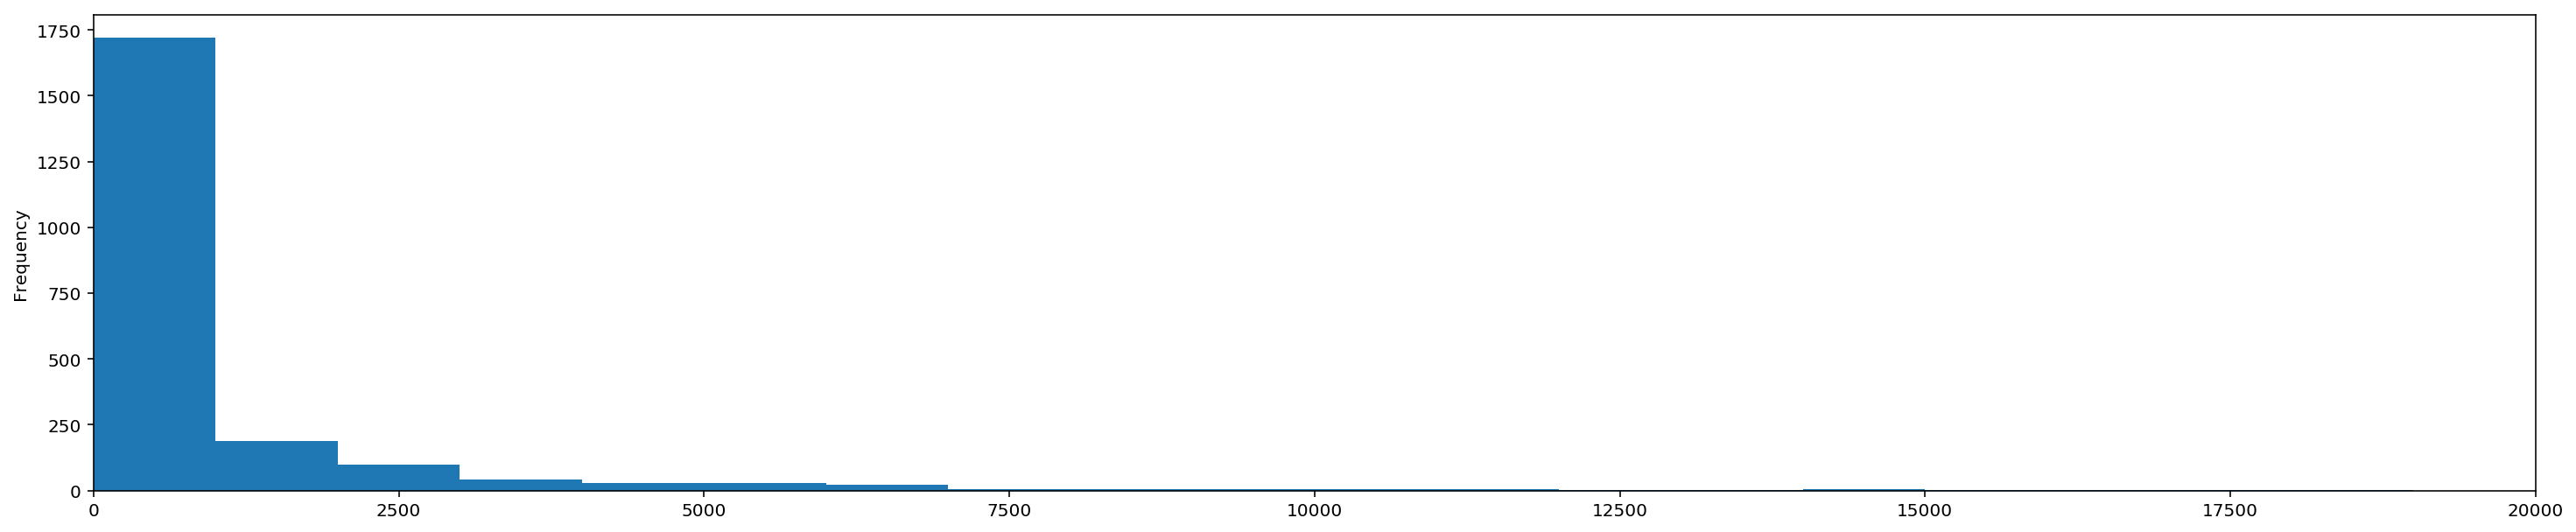

In [279]:
result["Spend"].plot(kind='hist', bins=85,figsize=(25,5), xlim=(0,20000))
#We can tell that $1000 is where a majority of the ad spending is concentrated on- we decided to make the cutoff
#for high and low spending to be at 1000. 

In [274]:
#New feature: High or low spending 
result['spending_brackets'] = (result.Spend <= 1000).replace({True:'Low', False:'High'})

In [275]:
result = result[['Impressions', 'StartDate', 'EndDate', 'spending_brackets', 'Spend','Gender', 'CountryCode']]
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.44406405257744236
rmse: 158832.3835568736


In [276]:
#New feature: Duration 
result['Duration'] = abs(dates['EndDate'] - dates['StartDate'])
result["Duration"] = round(result['Duration'].apply(lambda x: x.days * 24 + x.seconds // 3600))
#New feature: Media Type
result['spending_brackets'] = (result.Spend <= 1000).replace({True:'Low', False:'High'})

In [277]:
result = result[['Impressions', 'StartDate', 'EndDate', 'Duration', 'spending_brackets', 'Spend','Gender', 'CountryCode']]
types = X.dtypes
catcols = types.loc[types == np.object].index
numcols = types.loc[types != np.object].index

cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('pca', PCA(svd_solver='full', n_components=0.99))
])

ct = ColumnTransformer([
    ('catcols', cats, catcols),
    ('numcols', SimpleImputer(strategy='constant', fill_value=0), numcols)
])

pl2 = Pipeline([('feats', ct), ('reg', RandomForestRegressor())])

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
pl2.fit(X_tr, y_tr)
rsquared = pl2.score(X_ts, y_ts)
print("r-squared: " + str(rsquared))
preds = pl2.predict(X_ts)
rmse = np.sqrt(np.mean(preds - y_ts)**2)
print("rmse: " + str(rmse))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


r-squared: 0.6944131910870046
rmse: 30047.24719499477


### Fairness Evaluation

In [278]:
# X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
# pl2.fit(X_tr, y_tr)
# pl2.score(X_ts,y_ts)
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl2.fit(X_tr, y_tr)
    rsquared = pl2.score(X_ts, y_ts)
    out.append(rsquared)
np.mean(out)

LinAlgError: SVD did not converge

### Permutation Testing

In [ ]:
#RMSE fairness evaluation
low_list = []
high_list = []

for i in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
    pl2.fit(X_tr, y_tr)
    preds = pl2.predict(X_ts)

    results = pd.DataFrame()

    results["Observed"] = y_ts
    results["Prediction"] = preds
    results['High_or_Low'] = (results.Observed <= 3130994.5).replace({True:'Low', False:'High'})
    results = results[["High_or_Low", "Observed", "Prediction"]]

    high_df = results[results["High_or_Low"] == "High"]
    high_rmse = np.sqrt(np.mean(high_df["Prediction"] - high_df["Observed"])**2)
    high_list.append(high_rmse)

    low_df = results[results["High_or_Low"] == "Low"]
    low_rmse = np.sqrt(np.mean(low_df["Prediction"] - low_df["Observed"])**2)
    low_list.append(low_rmse)

#test stat = rmse
# null the high list performs better than the low list
np.count_nonzero(low_list >= high_list) / 100 # count how many times the low list does better than the high
# pval = 0, 100% of the time the high list performs worse than the low list, reject the null hyp

# low_list, high_list